# Marketing Campaign Notebook

### Scenario

You are a data analyst in bank and have the budget to contact only 100 people as part of a new marketing campaign. 
You can offer these customers 1 of 3 different products:
1.	Mutual Fund (MF)
2.	Credit Card (CC)
3.	Consumer Loan (CL)

Each of these 100 people can only receive 1 offer for 1 product.
The 100 people should not have been part of the previous marketing campaign

### Goal
Your goal in this task is to select the best 100 people and which product to offer them based on maximum potential revenue.

Your selection should be driven by the following key points:
1.	How likely the customer is to accept an offer from each product.
2.	How much revenue would be gained if the customer took that offer.

## Setting up the project

In the following cell, all relevant packages will be imported and all relevant directories will be set

In [1]:
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import classification_report
import tensorflow as tf

project_dir = Path.cwd().parent
upper_dir = project_dir.parent.parent
resources_dir = upper_dir / "VS Code Resources" / "Baeuda Resources"

marketing_dir = resources_dir / "Marketing Campaign"

Importing the data. The excel file contains multiple sheets. Setting ```sheet_name=None``` will return a dictionary with the sheet names as the key.

In [2]:
data_dir = marketing_dir / "Data.xlsx"
import_dataframe = pd.read_excel(data_dir,sheet_name=None)
print(import_dataframe.keys())

dict_keys(['Description', 'Soc_Dem', 'Products_ActBalance', 'Inflow_Outflow', 'Sales_Revenues'])


Each of the sheets are then converted to its own dataframe. The index for the dataframes was set to ```"Client"``` since that is common for all four sheets. Data on the dataframes are then processed. This involves removing invalid entries and replacing all NaN entries with 0 when applicable.

In [3]:
soc_dem_dataframe = import_dataframe["Soc_Dem"].set_index("Client")
check_row = soc_dem_dataframe[soc_dem_dataframe.isna().any(axis=1)]
print(f"Soc_Dem NaN entries: {check_row.shape}")
print(check_row.head())

products_act_dataframe = import_dataframe["Products_ActBalance"].set_index("Client")

check_row = products_act_dataframe[products_act_dataframe.isna().any(axis=1)]
print(f"Products_ActBalance NaN entries: {check_row.shape}")
print(check_row.head())

flow_dataframe = import_dataframe["Inflow_Outflow"].set_index("Client")

check_row = flow_dataframe[flow_dataframe.isna().any(axis=1)]
print(f"Inflow_Outflow NaN entries: {check_row.shape}")
print(check_row.head())

sales_dataframe = import_dataframe["Sales_Revenues"].set_index("Client")

check_row = sales_dataframe[sales_dataframe.isna().any(axis=1)]
print(f"Sales_Revenues NaN entries: {check_row.shape}")
print(check_row.head())


Soc_Dem NaN entries: (3, 3)
        Sex  Age  Tenure
Client                  
843     NaN   36     151
953     NaN   50      35
1363    NaN   38       8
Products_ActBalance NaN entries: (1614, 12)
        Count_CA  Count_SA  Count_MF  Count_OVD  Count_CC  Count_CL  \
Client                                                                
1              1       NaN       NaN        1.0       NaN       NaN   
2              1       1.0       NaN        NaN       NaN       NaN   
3              1       NaN       1.0        NaN       NaN       NaN   
4              1       1.0       NaN        NaN       1.0       NaN   
5              1       1.0       NaN        NaN       NaN       NaN   

          ActBal_CA     ActBal_SA   ActBal_MF  ActBal_OVD    ActBal_CC  \
Client                                                                   
1       1333.802857           NaN         NaN         0.0          NaN   
2        110.768571  13326.190357         NaN         NaN          NaN   
3        

Upon checking the imported dataframes, it can be observed that three clients have a NaN entry from the Soc_Dem sheet. There are 1614 clients with NaN entries in the Products_ActBalance sheet. The other two sheets are clear of NaN entries.

In the soc_dem_dataframe, it can be observed that the NaN entries are in a categorical column so it will be dropped. For the products_act_dataframe, all columns are numerical. One thing to note is that the NaN entries are in the columns for the number of live accounts. If a NaN entry is observed in a specific column type, say for example the savings, an NaN entry is also expected in the actual balance column of that type. These NaN entries can be replaced with 0.

The next cell will process the imported dataframes.

In [4]:
soc_dem_dataframe["Sex"] = soc_dem_dataframe["Sex"].replace("M", 0)
soc_dem_dataframe["Sex"] = soc_dem_dataframe["Sex"].replace("F", 1)

products_act_dataframe = import_dataframe["Products_ActBalance"].set_index("Client")
products_act_dataframe = products_act_dataframe.replace(np.nan, 0)

joined_dataframe = pd.concat([soc_dem_dataframe,products_act_dataframe,flow_dataframe,sales_dataframe], axis=1)

drop_condition = (soc_dem_dataframe["Sex"].isna())
joined_dataframe = joined_dataframe[~joined_dataframe.isin(joined_dataframe.loc[drop_condition])].dropna(how='all')

Printing the first 10 entries of the complete joined dataframe

In [5]:
joined_dataframe.head(10)

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
1,1.0,51.0,7.0,1.0,0.0,0.0,1.0,0.0,0.0,1333.802857,...,30.0,3.0,12.0,9.0,1.0,0.0,0.0,26.972679,0.0,0.0
2,0.0,43.0,152.0,1.0,1.0,0.0,0.0,0.0,0.0,110.768571,...,6.0,2.0,2.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,17.0,140.0,1.0,0.0,1.0,0.0,0.0,0.0,482.654643,...,3.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,24.0,153.0,1.0,1.0,0.0,0.0,1.0,0.0,1599.840714,...,36.0,6.0,12.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,58.0,200.0,1.0,1.0,0.0,0.0,0.0,0.0,5353.483929,...,41.0,4.0,17.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
6,1.0,24.0,19.0,1.0,0.0,0.0,0.0,0.0,1.0,4.297143,...,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,1.0,55.0,227.0,1.0,0.0,0.0,0.0,0.0,0.0,879.685000,...,10.0,1.0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,64.0,30.0,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,...,24.0,10.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,1.0,33.0,182.0,1.0,0.0,0.0,1.0,0.0,0.0,510.166429,...,7.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


Checking for NaN entries in the joined dataframe

In [6]:
check_row = joined_dataframe[joined_dataframe.isna().any(axis=1)]
print(f"Leftover NaN entries: {check_row.shape}")

Leftover NaN entries: (663, 35)


There are 664 rows within the joined dataframe that has at least a single NaN entry. This result can be explained by lookint at the entries in the ```Sales_Revenues``` sheet, which are incomplete as there are clients with no entries in any of the columns. These clients are the potential customers of the campaign.

A sorting condition can be used to extract all these clients.

In [7]:
sort_condition = (joined_dataframe["Sale_MF"].isna()) & (joined_dataframe["Sale_CC"].isna()) & (joined_dataframe["Sale_CL"].isna())
test_dataframe = joined_dataframe.loc[sort_condition]

leftover_dataframe = joined_dataframe[~joined_dataframe.isin(test_dataframe)].dropna(how='all')
print(f"Leftover Shape: {leftover_dataframe.shape}")
print(f"Test Shape: {test_dataframe.shape}")

Leftover Shape: (967, 35)
Test Shape: (645, 35)


The leftover frame has 969 remaining entries. It can also be observed that there 646 potential customers in the test dataframe.

There is a discrepancy somewhere in the data. Previously, it is known that there are 664 rows with at least a single NaN entry. However, only 646 rows was detected by the sort condition. This indicates that there are other rows in the leftover dataframe which has NaN entries that are not in the sales category. That will be checked in the next cell.

In [8]:
check_row = leftover_dataframe[leftover_dataframe.isna().any(axis=1)]
print(f"Leftover NaN entries: {check_row.shape}")
check_row.head(len(check_row))

Leftover NaN entries: (18, 35)


,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
50,1.0,33.0,109.0,1.0,0.0,0.0,0.0,0.0,0.0,169.563571,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.00
58,1.0,45.0,49.0,1.0,0.0,6.0,0.0,0.0,0.0,1263.052857,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.00
315,0.0,24.0,93.0,1.0,0.0,0.0,0.0,0.0,0.0,120.737143,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.00
334,1.0,49.0,163.0,1.0,0.0,0.0,0.0,0.0,0.0,23516.171429,...,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.786786,0.00
377,0.0,38.0,167.0,1.0,0.0,0.0,0.0,0.0,0.0,611.604643,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.00
514,0.0,77.0,129.0,1.0,0.0,0.0,0.0,0.0,0.0,27.090357,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.00
663,0.0,42.0,106.0,1.0,0.0,0.0,0.0,0.0,0.0,9.275000,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.00
723,0.0,59.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,444.290000,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.00
741,0.0,67.0,77.0,1.0,0.0,0.0,0.0,0.0,0.0,58.583929,...,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,8.934286,0.00


In the cell above, 18 more rows are discovered to have at least a single NaN entry from the leftover dataframe. This accounts for the discrepancy.

All the NaN entries are in the transactions columns. Checking the original sheet, it can also be observed that all these clients are missing. These clients will be dropped.

In [9]:
leftover_dataframe = leftover_dataframe[~leftover_dataframe.isin(check_row)].dropna(how='all')
print(f"Joined Dataframe Shape: {leftover_dataframe.shape}")

Joined Dataframe Shape: (949, 35)


## Preparing the dataset

In the following cells, information in the dataframe will be prepared.

Visualizing the distribution of the data.

In [10]:
visualize_dir = marketing_dir / "Visualize"

if not visualize_dir.exists():
    os.mkdir(visualize_dir)

for column in leftover_dataframe.columns[:-6]:
    plt.figure(figsize=(8,5))
    plt.hist(leftover_dataframe[column])
    plt.xlabel(f"Value")
    plt.ylabel(f"Instance")
    plt.title(f"{column}")

    plot_dir = visualize_dir / f"{column}.png"

    plt.savefig(plot_dir,bbox_inches="tight",transparent=True)
    plt.close()

In [11]:
raw_data = leftover_dataframe[leftover_dataframe.columns[:-6]].values
raw_output = leftover_dataframe[leftover_dataframe.columns[-6:]].values

# Data is split into two groups with 80, 20 split.

in_train, in_validate, out_train, out_validate = train_test_split(raw_data, raw_output, test_size=0.2, random_state=0)
print(f"Train In Shape: {in_train.shape} | Train Out Shape {out_train.shape}")
print(f"Validate In Shape: {in_validate.shape} | Validate Out Shape {out_validate.shape}")

# Splitting the sex category from the train and validate set

in_train_sex = in_train[:,0:1]
in_validate_sex = in_validate[:,0:1]
in_train_numerical = in_train[:,1:]
in_validate_numerical = in_validate[:,1:]

# Splitting the classifications from the outputs from the train and validate set

out_train_class = out_train[:,:3]
out_validate_class = out_validate[:,:3]
out_train_value = out_train[:,3:]
out_validate_value = out_validate[:,3:]

# Performing the scaling

scaler = StandardScaler()
scaler.fit(in_train_numerical)

#imputer = SimpleImputer(strategy='mean')
#imputer.fit(in_train_numerical)

scaled_train_numerical = scaler.transform(in_train_numerical)
scaled_validate_numerical = scaler.transform(in_validate_numerical)

# With the scaling performed, the two arrays can be joined

in_train_scaled = np.concatenate((in_train_sex,scaled_train_numerical),axis=1)
in_validate_scaled = np.concatenate((in_validate_sex,scaled_validate_numerical),axis=1)

Train In Shape: (759, 29) | Train Out Shape (759, 6)
Validate In Shape: (190, 29) | Validate Out Shape (190, 6)


## Model Creation

A multioutput regressor will be used for the output class

In [12]:
class_model = MultiOutputRegressor(LogisticRegression())
class_model.fit(in_train_scaled, out_train_class)

value_model = MultiOutputRegressor(LinearRegression())
value_model.fit(in_train_scaled, out_train_value)

MultiOutputRegressor(estimator=LinearRegression())

In [13]:
validate_prediction_class  = class_model.predict(in_validate_scaled)
validate_prediction_value  = value_model.predict(in_validate_scaled)

In [14]:
out_validate_class_MF = out_validate_class[:,0]
out_validate_class_CC = out_validate_class[:,1]
out_validate_class_CL = out_validate_class[:,2]

validate_prediction_MF = validate_prediction_value[:,0]
validate_prediction_CC = validate_prediction_value[:,1]
validate_prediction_CL = validate_prediction_value[:,2]

In [15]:
sorted_val = sorted(values)
print(sorted_val[-10:])

NameError: name 'values' is not defined

In [16]:
print(raw_data.shape)
print(in_train_scaled.shape)
print(in_validate.shape)
print(out_train_class.shape)

(949, 29)
(759, 29)
(190, 29)
(759, 3)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 16)                480       
                                                                 
 dense_26 (Dense)            (None, 64)                1088      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1763 (6.89 KB)
Trainable params: 1763 (6.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/100
16/16 [==============================] - 1s 10ms/step - loss: 0.6282 - accuracy: 0.2872 - val_loss: 0.5538 - val_accuracy: 0.2316
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5648 - accuracy: 0.3294 - val_loss: 0.5459 - val_accuracy: 0.3316
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5477 - accuracy: 0.3939 - val_loss: 0.5394 - val_accuracy: 0.3158
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5429 - accuracy: 0.3070 - val_loss: 0.5341 - val_accuracy: 0.3211
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5224 - accuracy: 0.4018 - val_loss: 0.5341 - val_accuracy: 0.3895
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5156 - accuracy: 0.3834 - val_loss: 0.5271 - val_accuracy: 0.3737
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5109 - accuracy: 0.3781 - val_loss: 0.5255 - val_accuracy: 0.3526
Epoch 8

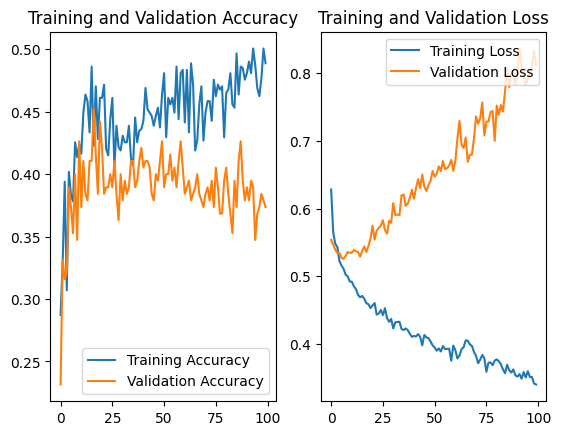

In [24]:
class_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu",input_shape = (29,)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(64, activation="relu"),
    #tf.keras.layers.Dense(64, activation="relu"),
    #tf.keras.layers.Dropout(0.75),
    #tf.keras.layers.Dense(160, activation="relu"),
    #tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(3,activation="sigmoid")
])
class_model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss="binary_crossentropy", metrics=["accuracy"])
print(class_model.summary())

epochs = 100
history = class_model.fit(in_train_scaled, out_train_class,epochs=epochs, validation_data=(in_validate_scaled, out_validate_class), batch_size=50)

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.close()
